In [8]:
import scanpy as sc
import scarches as sca
import pandas as pd
import numpy as np
from scarches.dataset.trvae.data_handling import remove_sparsity

In [177]:
path_data='/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/qtr/'
path_save=path_data+'integrated/gsCellType_query/'
path_gmt='/storage/groups/ml01/code/karin.hrovatin//qtr_intercode_reproducibility-/metadata/'

## Prepare ref and query

In [4]:
# Load data
adata=sc.read(path_data+'adata_annotated.h5ad')
adata.shape

(137964, 13520)

In [436]:
# Query info
ct_query='ductal' # Cell types containing this word are removed from reference (but not query)
study_query='NOD' # remove this study from reference and use as query

In [503]:
# Ref
# Subset to all but query study
adata_r=adata.raw.to_adata()[adata.obs.study!=study_query,:]
adata_r.obs['cell_type']=adata[adata_r.obs_names,:].obs.cell_type
print('Ref shape:',adata_r.shape)
# Ductal cells and ductal dublets not included in ref
adata_r=adata_r[~adata_r.obs.cell_type.str.contains(ct_query),:]
# Remove genes expressed in < 20 cells in ref
adata_r=adata_r[:,(adata_r.X!=0).sum(axis=0)>=20].copy()

# Remove top ambient genes
if False:
    ambient=pd.read_table(path_data+'ambient_genes_scores.tsv',index_col=0)
    ambient=set(ambient[(ambient>0.005).any(axis=1)].index)
    adata_r=adata_r[:,[g for g in adata_r.var_names if g not in ambient]]

print('Ref filtered shape:',adata_r.shape)

Trying to set attribute `.obs` of view, copying.


Ref shape: (135235, 30672)
Ref filtered shape: (129379, 20230)


In [504]:
# Add gene set anno to ref
# Omit gene sets not having at least 5 genes
sca.add_annotations(adata_r, path_gmt+'PanglaoDB_markers_27_Mar_2020_mouseEID.gmt', min_genes=5)
print('N used cell type gene sets:',adata_r.varm['I'].shape[1])

# Subset data to only genes in added gene sets
adata_r=adata_r[:,adata_r.varm['I'].sum(axis=1)>0].copy()
print('N retained genes',adata_r.shape[1])

N used cell type gene sets: 164
N retained genes 3860


In [505]:
# Query data - subset to query study cells and ref genes
adata_q=adata.raw.to_adata()[adata.obs.study==study_query,adata_r.var_names]
adata_q.obs['cell_type']=adata[adata_q.obs_names,:].obs.cell_type
print('Query shape:',adata_q.shape)

Trying to set attribute `.obs` of view, copying.


Query shape: (2729, 3860)


## Training

In [506]:
# Use whole datasets or only subset for testing out the scripts
testing=True
def subset_data(adata,proportion=0.05):
    np.random.seed(0)
    random_indices=np.random.permutation(list(range(adata.shape[0])))[:int(adata.shape[0]*0.05)]
    return adata[random_indices,:].copy()
if testing:
    adata_r_sub=subset_data(adata_r)
    adata_q_sub=subset_data(adata_q)
    adata_sub=subset_data(adata)
else:
    adata_r_sub=adata_r.copy()
    adata_q_sub=sadata_q.copu()
    adata_sub=adata.copy()

### Create TRVAE model and train it on reference dataset

In [497]:
model = sca.models.TRVAE(
    adata=remove_sparsity(adata_r_sub),
    condition_key='study_sample',
    hidden_layer_sizes=[512,512,512],
    use_mmd=False,
    recon_loss='nb',
    #beta=0.1,
    mask=adata_r.varm['I'].T,
    use_decoder_relu=False,
    mmd_instead_kl=False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3846 512 34
	Hidden Layer 1 in/out: 512 512
	Hidden Layer 2 in/out: 512 512
	Mean/Var Layer in/out: 512 164
Decoder Architecture:
	Masked linear layer in, out and cond:  164 3846 34


In [498]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
model.train(
    n_epochs=400,
    alpha_epoch_anneal=None, 
    alpha=0.1, # Higehr more integration
    alpha_kl=150, # Higehr more integration
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True, 
    seed=0
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Number of deactivated terms: 0
 |--------------------| 0.2%  - epoch_loss: 6358.06 - epoch_recon_loss: 6308.33 - epoch_kl_loss:   49.73 - val_loss: 6014.01 - val_recon_loss: 5891.64 - val_kl_loss:  122.37
Number of deactivated terms: 0
 |--------------------| 0.5%  - epoch_loss: 6267.00 - epoch_recon_loss: 6091.10 - epoch_kl_loss:  175.90 - val_loss: 5699.29 - val_recon_loss: 5470.50 - val_kl_loss:  228.78
Number of deactivated terms: 0
 |--------------------| 0.8%  - epoch_loss: 5970.59 - epoch_recon_loss: 5718.51 - epoch_kl_loss:  252.08 - val_loss: 5369.61 - val_recon_loss: 5090.08 - val_kl_loss:  279.53
Number of deactivated terms: 0
 |--------------------| 1.0%  - epoch_loss: 5661.46 - epoch_recon_loss: 5365.12 - epoch_kl_loss:  296.34 - val_loss: 5628.19 - val_recon_loss: 5283.37 - val_kl_loss:  344.82
Number of deactivated terms: 0
 |--------------------| 1.2%  - epoch_loss: 5560.17 - epoch_recon_loss: 5242.86 - epoch_kl_loss:  317.31 - val_loss: 4939.89 - val_recon_loss: 4623.2

 |██------------------| 10.0%  - epoch_loss: 4516.91 - epoch_recon_loss: 4330.23 - epoch_kl_loss:  186.68 - val_loss: 4234.87 - val_recon_loss: 4050.30 - val_kl_loss:  184.57
Number of deactivated terms: 0
 |██------------------| 10.2%  - epoch_loss: 4575.17 - epoch_recon_loss: 4389.14 - epoch_kl_loss:  186.03 - val_loss: 4293.45 - val_recon_loss: 4102.83 - val_kl_loss:  190.62
Number of deactivated terms: 0
 |██------------------| 10.5%  - epoch_loss: 4439.37 - epoch_recon_loss: 4256.20 - epoch_kl_loss:  183.17 - val_loss: 4093.96 - val_recon_loss: 3923.95 - val_kl_loss:  170.01
Number of deactivated terms: 0
 |██------------------| 10.8%  - epoch_loss: 4440.80 - epoch_recon_loss: 4259.13 - epoch_kl_loss:  181.67 - val_loss: 4080.01 - val_recon_loss: 3904.44 - val_kl_loss:  175.57
Number of deactivated terms: 0
 |██------------------| 11.0%  - epoch_loss: 4501.70 - epoch_recon_loss: 4318.80 - epoch_kl_loss:  182.90 - val_loss: 4136.57 - val_recon_loss: 3960.52 - val_kl_loss:  176.05
N

In [499]:
# Remove inactivated terms
adata_r_sub.uns['terms_is_active'] = \
    (model.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()
print('Inactive terms:')
print([term for i, term in enumerate(adata_r_sub.uns['terms']) 
       if not adata_r_sub.uns['terms_is_active'][i]])

Inactive terms:
[]


In [500]:
# Add integrated embedding
adata_r_sub.obsm['X_integrated'] = model.get_latent(mean=True)[:, adata_r_sub.uns['terms_is_active']]

In [501]:
# Compute neighbours and UMAP
sc.pp.neighbors(adata_r_sub, use_rep='X_integrated')
sc.tl.umap(adata_r_sub)

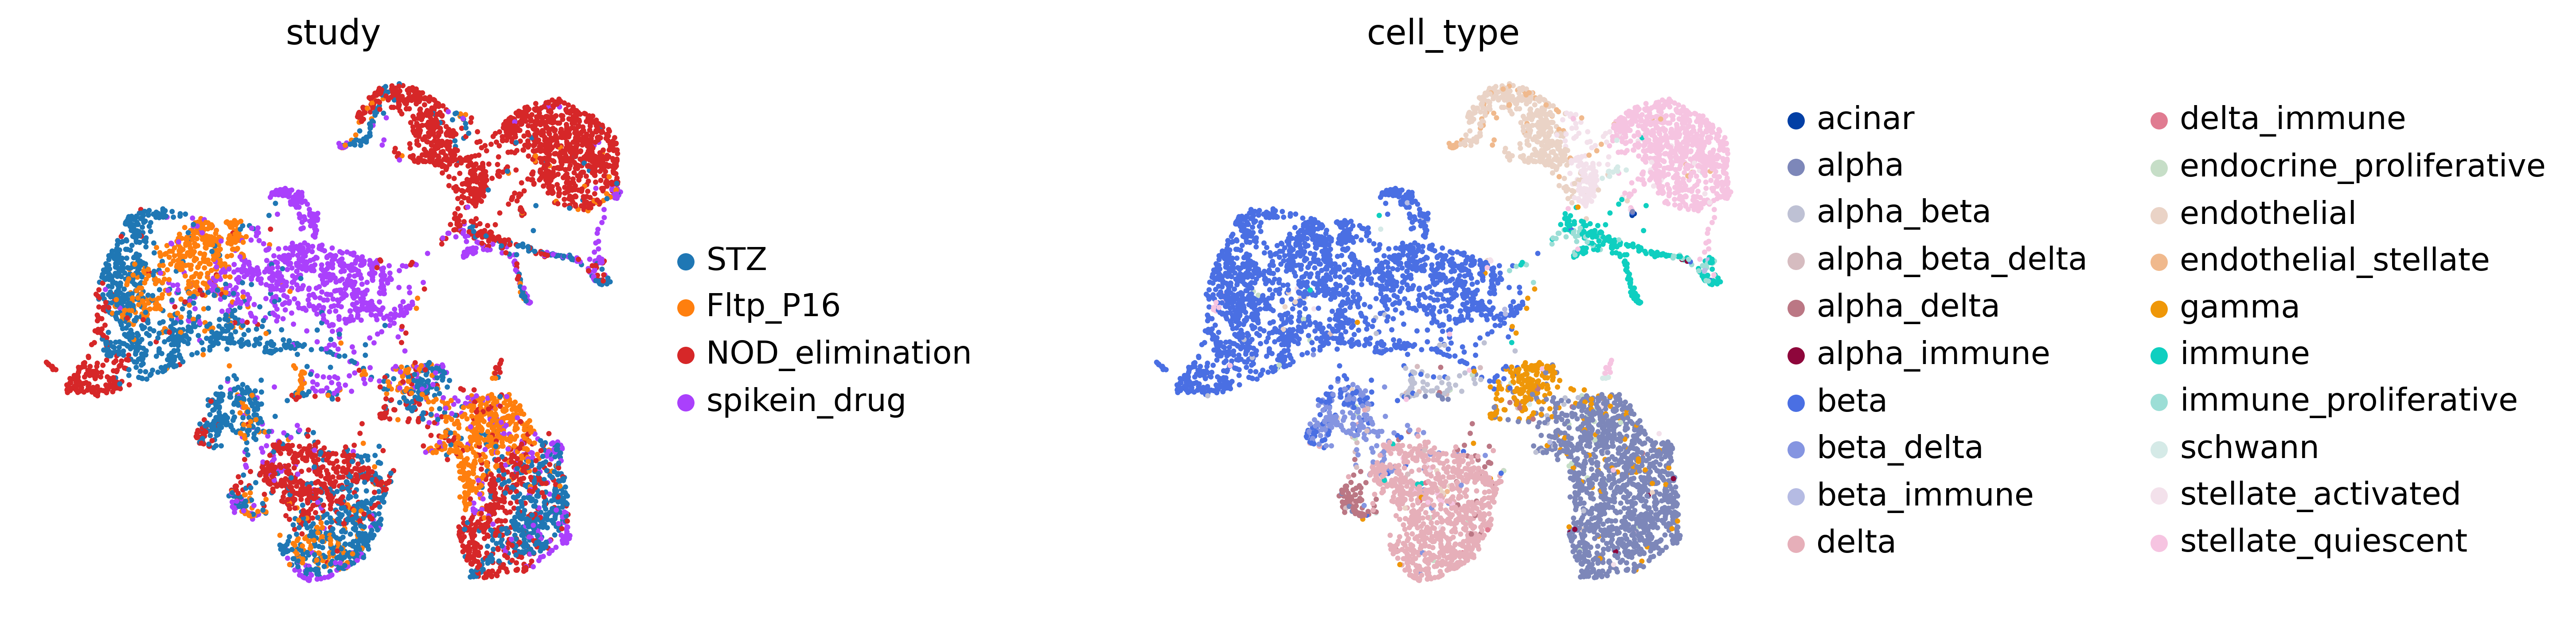

In [460]:
# Plot integrated UMAP
sc.pl.umap(adata_r_sub, color=['study', 'cell_type'], frameon=False, wspace=0.6)

In [31]:
# TODO save data

In [13]:
# Save model
# model.save(path_save)

### Add query

In [468]:
# Make query model from original model
model_q = sca.models.TRVAE.load_query_data(remove_sparsity(adata_q_sub), model)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3860 512 37
	Hidden Layer 1 in/out: 512 512
	Hidden Layer 2 in/out: 512 512
	Mean/Var Layer in/out: 512 164
Decoder Architecture:
	Masked linear layer in, out and cond:  164 3860 37


In [469]:
# Train query model
model_q.train(
    n_epochs=400,
    alpha_epoch_anneal=None,  
    alpha_kl=100, 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True, 
    weight_decay=0,
    seed=0
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |█-------------------| 9.2%  - epoch_loss: 31723.79 - epoch_recon_loss: 31318.94 - epoch_kl_loss:    4.05 - val_loss: 35194.46 - val_recon_loss: 34756.21 - val_kl_loss:    4.38
ADJUSTED LR
 |██------------------| 13.0%  - epoch_loss: 33960.67 - epoch_recon_loss: 33553.79 - epoch_kl_loss:    4.07 - val_loss: 34545.70 - val_recon_loss: 34107.09 - val_kl_loss:    4.39
ADJUSTED LR
 |███-----------------| 17.2%  - epoch_loss: 37046.73 - epoch_recon_loss: 36631.07 - epoch_kl_loss:    4.16 - val_loss: 35726.38 - val_recon_loss: 35287.74 - val_kl_loss:    4.39
ADJUSTED LR
 |███-----------------| 19.0%  - epoch_loss: 30960.35 - epoch_recon_loss: 30580.05 - epoch_kl_loss:    3.80 - val_loss: 35872.70 - val_recon_loss: 35434.05 - val_kl_loss:    4.39
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 54


### Prediction Q&R with Q model
Prediction from query adapated model for all data: Q & R (including the previously ommited cell type).

In [470]:
# Prediction 
adata_sub.obsm['X_integrated'] = model_q.get_latent(
    remove_sparsity( adata_sub.raw.to_adata()[:,adata_r.var_names]).X, 
    adata_sub.obs['study_sample'], mean=True
    )[:, adata_r_sub.uns['terms_is_active']]

In [471]:
# Compute neighbours and UMAP
sc.pp.neighbors(adata_sub, use_rep='X_integrated')
sc.tl.umap(adata_sub)

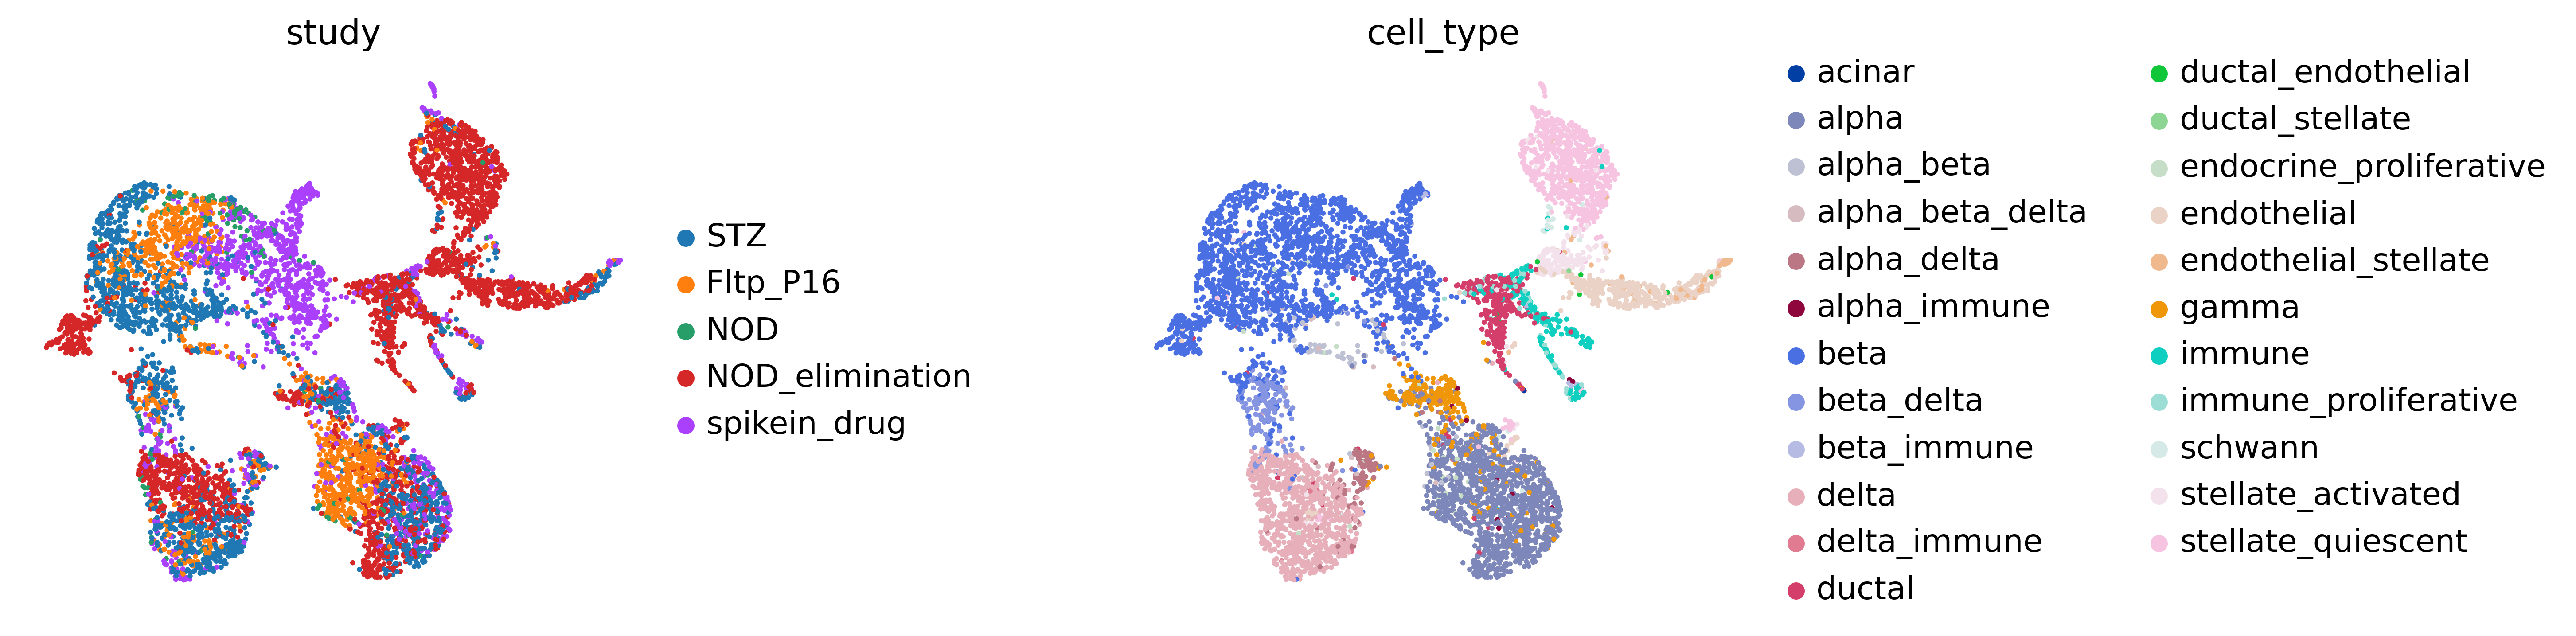

In [472]:
# Plot integrated embedding
sc.pl.umap(adata_sub, color=['study', 'cell_type'], frameon=False, wspace=0.6)